In [1]:
from pylab import*
import numpy as np
from scipy.optimize import bisect
from math import pi
import cmath
from fompy.constants import eV, me, h_bar
from fompy.units import unit

In [2]:
# Periodic potential:
# U = 0,    n*(a+b) < x < n*(a+b) + a
# U = U_0,  n*(a+b) + a <= (n+1)*(a + b)
# предполагаем, что b - тонкий высокий барьер, а - межбарьерное расстояние

In [3]:
def equation_left(a, b, E):
    alf = cmath.sqrt(2*m/h_bar**2*(E))
    bet = cmath.sqrt(2*m/h_bar**2*(E - U_0))
    first = cmath.cos(bet*b)*cmath.cos(alf*a)
    if bet == 0:
        second = -(alf*b/2)*cmath.sin(alf*a)
    elif alf == 0:
        second = -(bet*a/2)*cmath.sin(bet*b)
    else:
        second = -(bet**2 + alf**2)/(2*alf*bet)*cmath.sin(bet*b)*cmath.sin(alf*a)
    return (first + second).real
    
def equation_right(a, b, k):
    return cmath.cos(k * (a + b)).real

def generic_equation(E, k, a, b, U0, m):
    return equation_left(a, b, E) - equation_right(a, b, k)

def find_E_start_end(a,b,U_0,m,E_0,accuracy):
    alpha = (2*m/h_bar**2)**0.5
    E_start,E_end = E_0,E_0
    E_step = U_0/100000
    cur_E = E_start
    step = E_step
    process_started = False
    while(True):
        if(not process_started):
            if(equation_left(a,b,cur_E) < 1.0):
                cur_E -= step
            else:
                process_started = True
        elif(equation_left(a,b,cur_E) > 1.0):
            cur_E += step
        elif(equation_left(a,b,cur_E) < 1.0):
            if(step < accuracy):
                E_start = cur_E
                break
            step /= 2.
            cur_E -= step
        else:
            E_start = cur_E
            break
    step = E_step
    minus_one_achieved = False
    while(True):
        g = alpha*((U_0 - cur_E)**0.5)
        beta = alpha*((cur_E)**0.5)
        if(equation_left(a,b,cur_E) > -1.0):
            if(minus_one_achieved and step < accuracy):
                E_end = cur_E
                break
            cur_E += step
        elif(equation_left(a,b,cur_E) < -1.0):
            minus_one_achieved = True
            step /= 2.
            cur_E -= step
        else:
            E_end = cur_E
            break
    return E_start,E_end

In [4]:
m = 0.49 * me
a = 10 * unit('nm')
b = 5 * unit('nm')
U_0 = 0.58 * eV

N = 100
E_0 = U_0 - U_0/N                 # first non-zero approximation
accuracy = U_0/10000000     # accuracy with to find E_start, E_end

E_start,E_end = find_E_start_end(a,b,U_0,m,E_0,accuracy)
print("For first Brullien zone")
print("E_min, eV = ",E_start/eV)
print("E_max, eV = ", E_end/eV)

For first Brullien zone
E_min, eV =  0.5175598734376184
E_max, eV =  0.5184961429688665


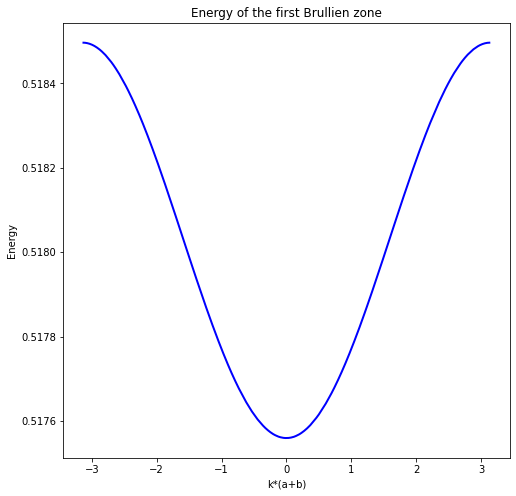

In [5]:
@np.vectorize
def get_energy(k):
    try:
        return bisect(generic_equation, E_start, E_end, (k, a, b, U_0, m), xtol=accuracy)
    except ValueError:
        return None

def filter_gaps(ks, es):
    _es = []
    _ks = []
    for e, k in zip(es, ks):
        if e is not None:
            _es.append(e)
            _ks.append(k)
    return np.array(_ks), np.array(_es)
    
kas = np.linspace(-pi, pi, 1000)
es = get_energy(kas/(a+b))
kas, es = filter_gaps(kas, es)

# plot graph
fig,axes = plt.subplots(nrows = 1, ncols = 1)

axes.plot(kas, es/eV, lw = 2, color = 'b', alpha = 1)
axes.set_xlabel("k*(a+b)")
axes.set_ylabel("Energy")
axes.set_title("Energy of the first Brullien zone")

fig.set_figwidth(8)
fig.set_figheight(8)
plt.show()